In [1]:
%matplotlib inline

import xgboost as xgb

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import operator
import os
import pickle

# CONFIGURATIONS

In [14]:
sns.set(context="notebook", style="ticks", font_scale=1.5)
figsize=(10,7.5)

# PATHS

In [3]:
FEATURES_PATH = "E:\\eaglesense\\data\\topviewkinect\\all\\eval-chi2"

In [4]:
FIGS_DIR = "figs"
FIGS_HIGH_DIR = "figs/high"

if not os.path.exists(FIGS_DIR):
    os.makedirs(FIGS_DIR)
if not os.path.exists(FIGS_HIGH_DIR):
    os.makedirs(FIGS_HIGH_DIR) 
    
FIG_TEMPLATE = FIGS_DIR + "/{}.png"
FIG_HIGH_TEMPLATE = FIGS_HIGH_DIR + "/{}.pdf"

#  LOAD DATA

In [5]:
features_csv = "{path}_features.csv".format(path=FEATURES_PATH)
features_df = pd.read_csv(features_csv)

In [6]:
labels_csv = "{path}_labels.csv".format(path=FEATURES_PATH)
labels_df = pd.read_csv(labels_csv)

# ACTIVITIES

In [7]:
ACTIVITIES = ["Standing", "Sitting", "Pointing", "Phone", "Tablet", "Paper"]

# FEATURES

In [8]:
features_vector = features_df.drop(["subject"], axis=1)

In [9]:
output_vector = labels_df.drop(["subject"], axis=1)

In [10]:
num_features = features_vector.shape[1]
num_features

72

In [11]:
features_corr = features_vector.corr()

In [12]:
# new_features_df = pd.DataFrame(columns=["feature_x", "feature_y", "correlation"])
# for feature_name, correlation_values in features_corr.iterrows():
#     for feature in features:
#         new_features_df.loc[len(new_features_df)] = [feature_name, feature, correlation_values[feature]]
# new_features_df.head()
# new_features_df_pivoted = new_features_df.pivot("feature_x", "feature_y", "correlation")
# new_features_df_pivoted.head()

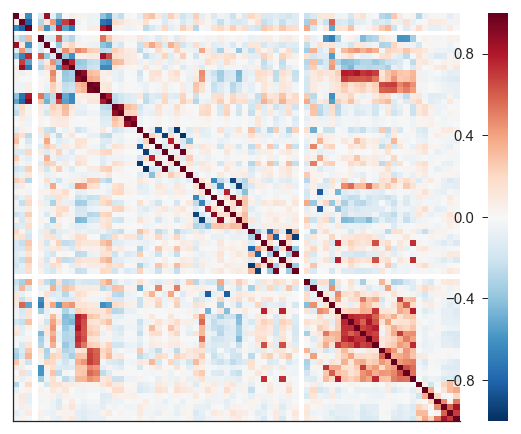

In [13]:
FIG_FEATURES_CORRELATION = "features_correlation"

fig, ax = plt.subplots(figsize=figsize)
# sns.clustermap(new_features_df_pivoted)
x = sns.heatmap(features_corr, ax=ax, xticklabels=False, yticklabels=False)
sns.despine()
plt.yticks(rotation=0)

plt.savefig(FIG_TEMPLATE.format(FIG_FEATURES_CORRELATION), bbox_inches="tight")
plt.savefig(FIG_HIGH_TEMPLATE.format(FIG_FEATURES_CORRELATION), bbox_inches="tight")

# OVERVIEW 

In [14]:
X = features_vector.values

In [15]:
y = output_vector[["activity"]].values

In [16]:
y_bins = np.bincount(np.squeeze(y))

In [17]:
activities_df = pd.DataFrame({
    "activity": ACTIVITIES,
    "size": y_bins
})

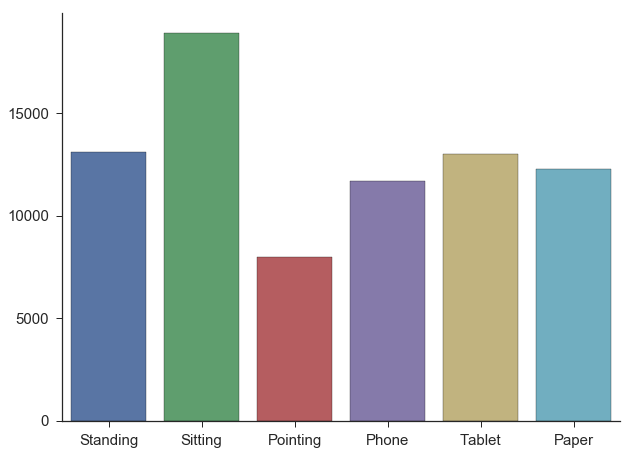

In [18]:
FIG_DATA_ACTIVITIES = "activities"

fig, ax = plt.subplots(figsize=figsize)
sns.barplot(x="activity", y="size", data=activities_df, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine()

plt.savefig(FIG_TEMPLATE.format(FIG_DATA_ACTIVITIES), bbox_inches="tight")
plt.savefig(FIG_HIGH_TEMPLATE.format(FIG_DATA_ACTIVITIES), bbox_inches="tight")

In [19]:
unique_subjects = features_df["subject"].unique()

In [20]:
activities_per_subject_df = pd.DataFrame(columns=["Subject", "Activity", "Size"])

for subject_id in unique_subjects:
    subject = str(subject_id)[2:4]
    subject_activities = labels_df[labels_df["subject"] == subject_id]["activity"].values
    subject_activities_bin = np.bincount(np.squeeze(subject_activities))
    
    for activity_id, activity in enumerate(ACTIVITIES):
        num_activity_samples = subject_activities_bin[activity_id]
        activities_per_subject_df.loc[len(activities_per_subject_df)] = [subject, activity, num_activity_samples]

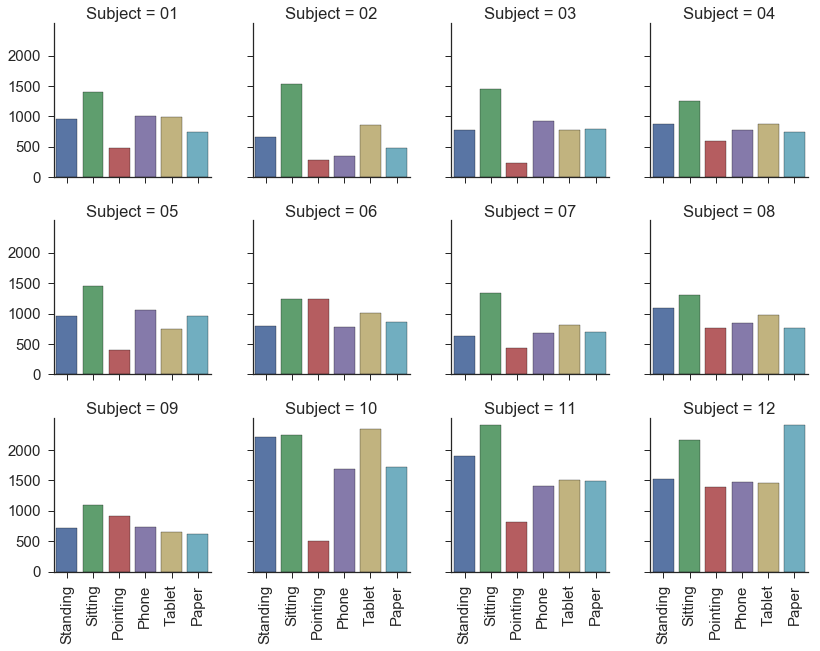

In [21]:
FIG_DATA_ACTIVITIES_SUBJECT = "activities_per_subject"

g = sns.FacetGrid(data=activities_per_subject_df, col="Subject", col_wrap=4)
g = (g.map(sns.barplot, "Activity", "Size", palette=sns.color_palette(), ci=None)
     .set_xlabels("")
     .set_ylabels("")
     .set_xticklabels(rotation=90))
g.despine()
plt.yticks(np.arange(0, 2500, 500))

plt.savefig(FIG_TEMPLATE.format(FIG_DATA_ACTIVITIES_SUBJECT), bbox_inches="tight")
plt.savefig(FIG_HIGH_TEMPLATE.format(FIG_DATA_ACTIVITIES_SUBJECT), bbox_inches="tight")

# UTILITY 

In [22]:
def plot_evaluation(title, evaluation_results, best_iteration, best_score):
    # Create evaluation dataframe
    iterations = list(range(len(evaluation_results["eval"]["merror"]))) * 2
    num_iterations = len(iterations)
    errors = evaluation_results["eval"]["merror"] + evaluation_results["train"]["merror"]
    types = ["Validation"] * int(num_iterations/2) + ["Train"] * int(num_iterations/2)
    units = [0] * num_iterations
    data = {
        "Number of boosting rounds": iterations,
        "Mean multiclass classification error rate": errors,
        "Type": types,
        "unit": units
    }
    evaluation_dataframe = pd.DataFrame(data)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot([best_iteration], [best_score], 'o', markersize=20.0, markerfacecolor="None", markeredgecolor="green", markeredgewidth=3)

    sns.tsplot(data=evaluation_dataframe, color=sns.color_palette("Set1"), ax=ax,
               time="Number of boosting rounds", value="Mean multiclass classification error rate", 
               condition="Type", unit="unit")
    sns.despine()
    ax.set_title(title)
    ax.legend().title = ""
    
    # Anonotations
    ax.annotate("Best iteration (early-stopping): {}".format(best_iteration), xy=(0.05, 0.95), xycoords="axes fraction",
               fontsize=14)
    ax.annotate("Best score (early-stopping): {}".format(best_score), xy=(0.05, 0.90), xycoords="axes fraction",
               fontsize=14)

    return fig, ax

In [12]:
def plot_confusion_matrix(title, confusion_matrix):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(data=confusion_matrix, annot=True, fmt=".2f", linewidths=1, square=True,
                vmin=0, vmax=100, ax=ax, xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.yticks(rotation=0)
    sns.despine()
#     ax.set_title(title)
    return fig, ax

# LOAD RESULTS

In [24]:
with open("results/s1.pickle", "rb") as f:
    s1_results = pickle.load(f)

s1_eval_results = s1_results["eval_results"]
s1_eval_best_iteration = s1_results["eval_earlystoppping_best_iteration"]
s1_eval_best_score = s1_results["eval_earlystoppping_best_score"]
s1_accuracy = s1_results["final_accuracy"]
s1_confusion_matrix = s1_results["final_confusion_matrix"]

In [25]:
with open("results/s2.pickle", "rb") as f:
    s2_results = pickle.load(f)

s2_eval_results = s2_results["eval_results"]
s2_eval_best_iteration = s2_results["eval_earlystoppping_best_iteration"]
s2_eval_best_score = s2_results["eval_earlystoppping_best_score"]
s2_accuracy = s2_results["final_accuracy"]
s2_confusion_matrix = s2_results["final_confusion_matrix"]

In [2]:
with open("results/cs.pickle", "rb") as f:
    cs_results = pickle.load(f)

cs_training_time = cs_results["training_time"]
cs_testing_time = cs_results["testing_time"]
cs_eval_results = cs_results["eval_results"]
cs_eval_best_iteration = cs_results["eval_earlystoppping_best_iteration"]
cs_eval_best_score = cs_results["eval_earlystoppping_best_score"]
cs_accuracy = cs_results["final_accuracy"]
cs_training_accuracy = cs_results["training_accuracy"]
cs_confusion_matrix = cs_results["final_confusion_matrix"]
cs_classifier = cs_results["classifier"]
cs_confusion_matrix_subjects = cs_results["subject_confusion_matrix"]

In [27]:
with open("results/cs_rf.pickle", "rb") as f:
    cs_rf_results = pickle.load(f)

cs_rf_training_time = cs_rf_results["training_time"]
cs_rf_testing_time = cs_rf_results["testing_time"]
cs_rf_training_accuracy = cs_rf_results["training_accuracy"]
cs_rf_accuracy = cs_rf_results["final_accuracy"]
cs_rf_confusion_matrix = cs_rf_results["final_confusion_matrix"]

In [28]:
with open("results/cs_noinfrared.pickle", "rb") as f:
    noinfrared_results = pickle.load(f)

noinfrared_confusion_matrix = noinfrared_results["final_confusion_matrix"]

In [107]:
with open("results/cs_combinations.pickle", "rb") as f:
    combinations_results = pickle.load(f)

combinations_confusion_matrix = combinations_results["confusion_matrix"]

# PLOT EVALUATION

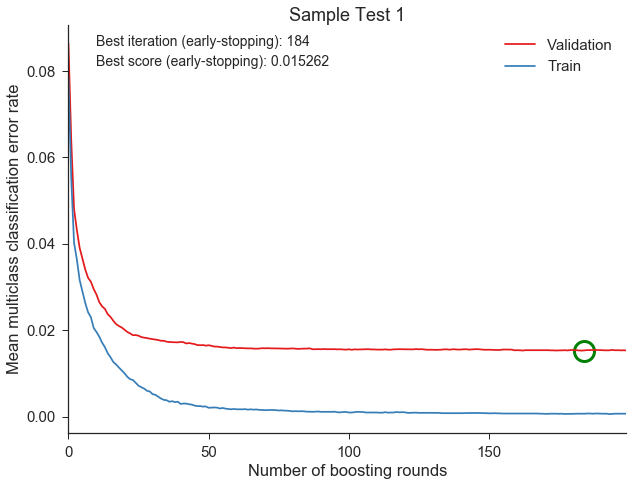

In [81]:
fig, ax = plot_evaluation("Sample Test 1", s1_eval_results, s1_eval_best_iteration, s1_eval_best_score)
FIG_S1_EVAL_ITERATIONS = "s1_iterations"
fig.savefig(FIG_TEMPLATE.format(FIG_S1_EVAL_ITERATIONS), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_S1_EVAL_ITERATIONS), bbox_inches="tight")

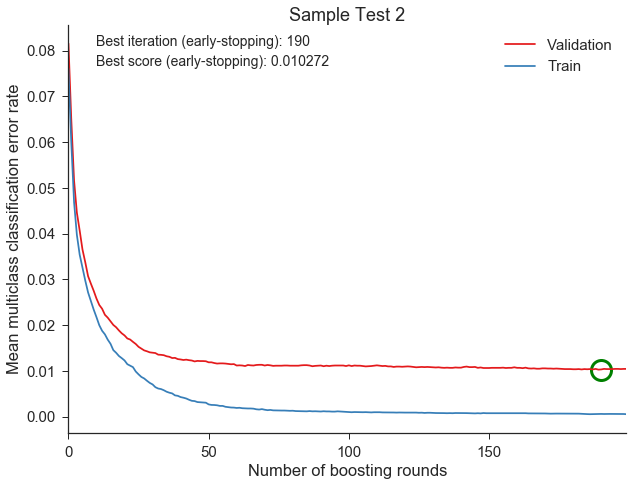

In [82]:
fig, ax = plot_evaluation("Sample Test 2", s2_eval_results, s2_eval_best_iteration, s2_eval_best_score)
FIG_S2_EVAL_ITERATIONS = "s2_evaluation_iterations"
fig.savefig(FIG_TEMPLATE.format(FIG_S2_EVAL_ITERATIONS), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_S2_EVAL_ITERATIONS), bbox_inches="tight")

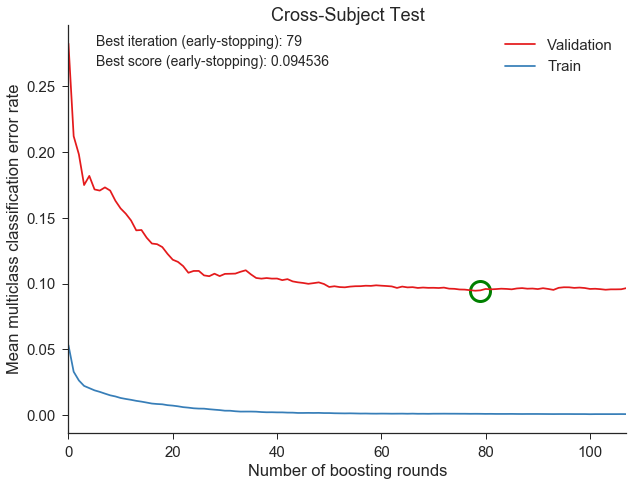

In [83]:
fig, ax = plot_evaluation("Cross-Subject Test", cs_eval_results, cs_eval_best_iteration, cs_eval_best_score)
FIG_CS_EVAL_ITERATIONS = "cs_evaluation_iterations"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_EVAL_ITERATIONS), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_EVAL_ITERATIONS), bbox_inches="tight")

# PLOT CONFUSION MATRIX

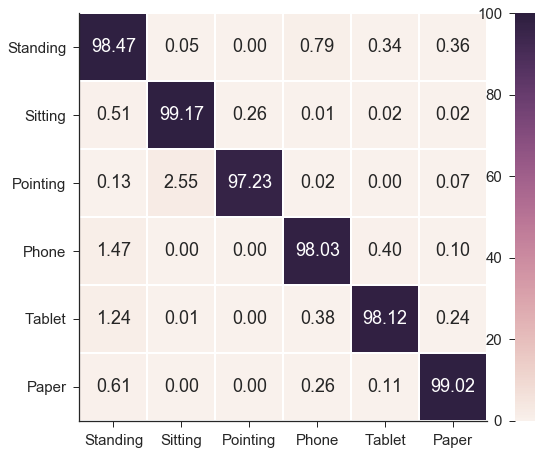

In [84]:
fig, ax = plot_confusion_matrix("Samples Test 1", s1_confusion_matrix)
FIG_S1_CONFUSION_MATRIX = "s1_confusion_matrix"
fig.savefig(FIG_TEMPLATE.format(FIG_S1_CONFUSION_MATRIX), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_S1_CONFUSION_MATRIX), bbox_inches="tight")

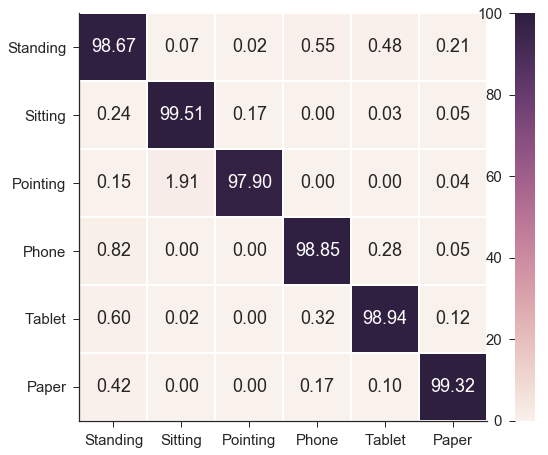

In [85]:
fig, ax = plot_confusion_matrix("Samples Test 2", s2_confusion_matrix)
FIG_S2_CONFUSION_MATRIX = "s2_confusion_matrix"
fig.savefig(FIG_TEMPLATE.format(FIG_S2_CONFUSION_MATRIX), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_S2_CONFUSION_MATRIX), bbox_inches="tight")

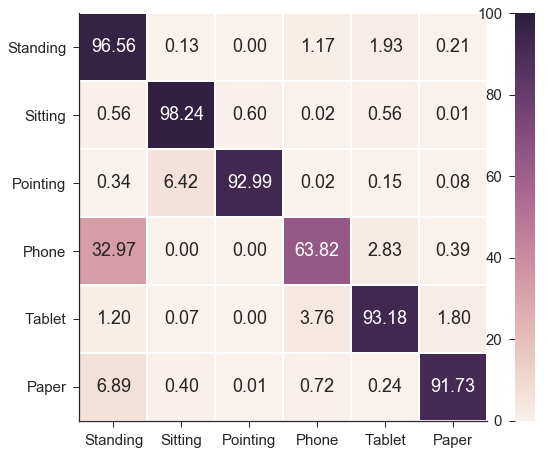

In [86]:
fig, ax = plot_confusion_matrix("Cross-Subject Test", cs_confusion_matrix)
FIG_CS_CONFUSION_MATRIX = "cs_confusion_matrix"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX), bbox_inches="tight")

In [ ]:
# paper figs

In [5]:
ACTIVITIES = ["Standing", "Sitting", "Pointing", "Phone", "Tablet", "Paper"]

In [6]:
sns.set()
sns.set(context="notebook", style="ticks", font_scale=1.8)
figsize=(10, 7.5)

In [37]:
init_cs = pd.read_csv("Q:\\p_eaglesense\\CHI\\figs\\Figure 7 left.csv", header=None)

In [38]:
init_cs

,0,1,2,3,4,5
0,96.56,0.13,0.00,1.17,1.93,0.21
1,0.54,98.24,0.60,0.02,0.56,0.01
2,0.34,6.42,92.99,0.02,0.15,0.08
3,32.97,0.00,0.00,63.82,2.83,0.39
4,1.20,0.07,0.00,3.76,93.18,1.80
5,6.89,0.40,0.01,0.72,0.24,91.73


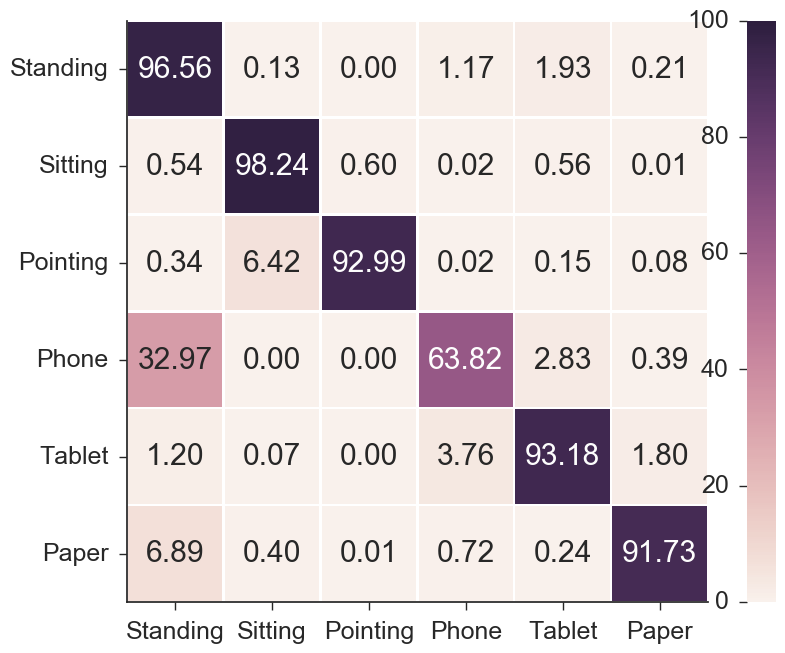

In [84]:
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data=init_cs, annot=True, fmt=".2f", linewidths=1, square=True,
            vmin=0, vmax=100, ax=ax, xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.yticks(rotation=0)
sns.despine()
fig.savefig("Q:\\p_eaglesense\\CHI\\figs\\Figure 7 left-600dpi.png", bbox_inches="tight", dpi=600)

In [86]:
complete_cs = pd.read_csv("Q:\\p_eaglesense\\CHI\\figs\\Figure 7 right.csv", header=None)

In [87]:
complete_cs

,0,1,2,3,4,5
0,96.70,0.14,0.02,1.24,1.21,0.68
1,0.52,96.33,2.76,0.02,0.27,0.10
2,2.89,4.19,92.61,0.03,0.19,0.10
3,22.46,0.02,0.01,71.59,2.67,3.24
4,5.54,0.10,0.01,9.48,83.30,1.56
5,3.91,0.40,0.09,2.21,0.57,92.81


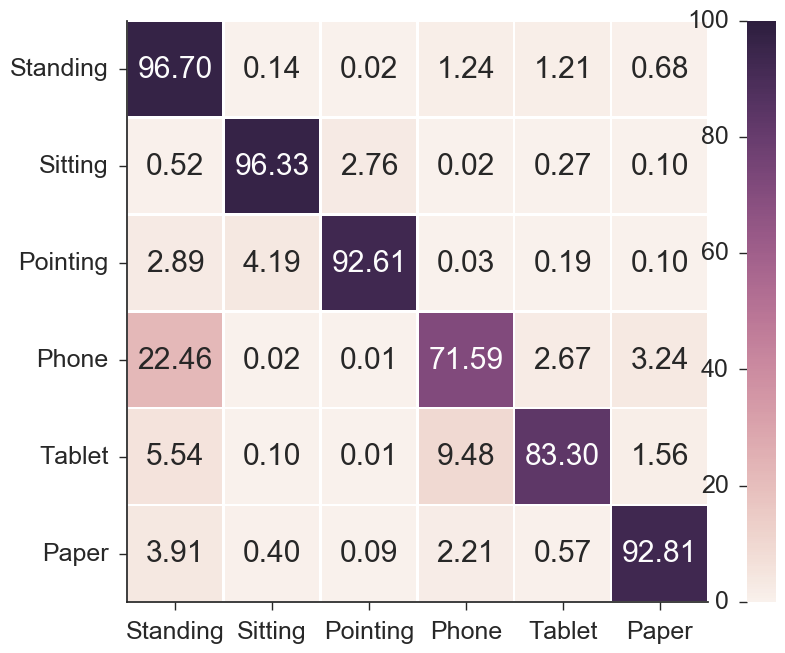

In [88]:
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data=complete_cs, annot=True, fmt=".2f", linewidths=1, square=True,
            vmin=0, vmax=100, ax=ax, xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.yticks(rotation=0)
sns.despine()
fig.savefig("Q:\\p_eaglesense\\CHI\\figs\\Figure 7 right-600dpi.png", bbox_inches="tight", dpi=600)

In [63]:
infrared_compared = pd.read_csv("Q:\\p_eaglesense\\CHI\\figs\\Figure 8.csv", header=None)

In [64]:
infrared_compared

,0,1
0,96.56,98.01
1,98.24,98.47
2,92.99,93.18
3,63.84,53.55
4,93.18,60.06
5,91.73,86.53


In [65]:
infrared_compared_df = pd.DataFrame(columns=["Activity", "Accuracy", "Condition"])
for idx, activity in enumerate(ACTIVITIES):
    infrared_accuracy = infrared_compared.loc[idx, 0]
    noinfrared_accuracy = infrared_compared.loc[idx, 1]
    infrared_compared_df.loc[len(infrared_compared_df)] = [
        activity, infrared_accuracy, "All"
    ]
    infrared_compared_df.loc[len(infrared_compared_df)] = [
        activity, noinfrared_accuracy, "No Infrareds"
    ]

In [66]:
color = sns.color_palette()

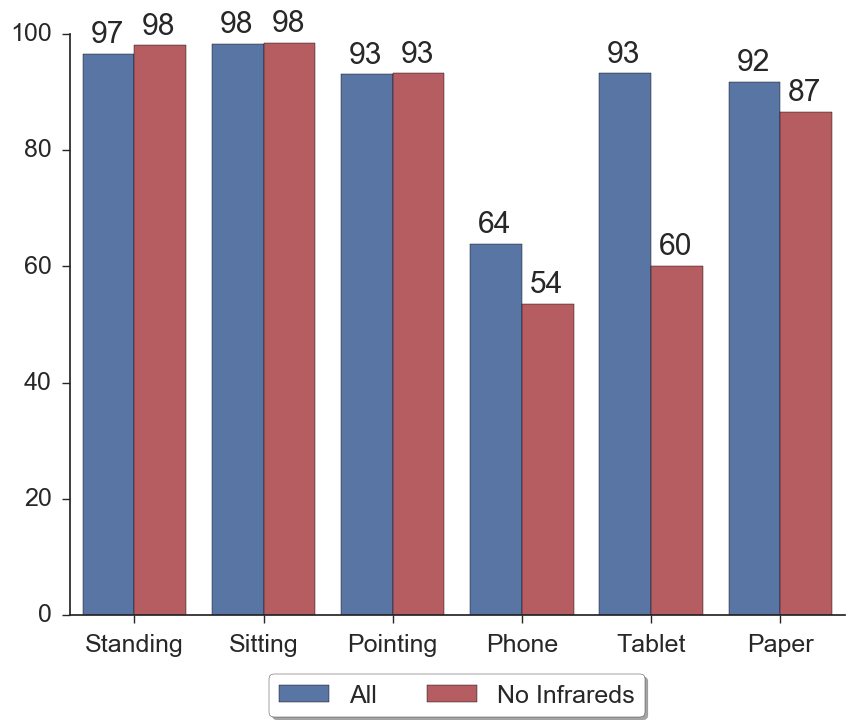

In [89]:
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=infrared_compared_df, ax=ax,
            x="Activity", y="Accuracy", hue="Condition", palette=[color[0], color[2]])
sns.despine()
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), frameon=True, framealpha=1, fancybox=True, shadow=True, ncol=2)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+0.06, height+2, "%1.0f"%(height))
fig.savefig("Q:\\p_eaglesense\\CHI\\figs\\Figure 8-600dpi.png", bbox_inches="tight", dpi=600)

In [13]:
np.set_printoptions(formatter={'float': lambda x: "{:.2f}".format(x)})

In [18]:
cs_confusion_matrix_subjects

[(2001.0, 0.9980318482733942, array([[100.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 99.93, 0.07, 0.00, 0.00, 0.00],
         [0.00, 1.06, 98.94, 0.00, 0.00, 0.00],
         [0.49, 0.00, 0.00, 99.51, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 100.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 100.00]])),
 (2002.0, 0.90640038498556308, array([[96.19, 0.61, 0.00, 0.76, 1.98, 0.46],
         [0.71, 99.22, 0.06, 0.00, 0.00, 0.00],
         [2.84, 10.28, 84.75, 0.00, 1.77, 0.35],
         [11.37, 0.00, 0.00, 58.60, 25.95, 4.08],
         [1.41, 0.12, 0.00, 0.00, 84.29, 14.19],
         [4.78, 1.66, 0.00, 0.00, 0.42, 93.14]])),
 (2003.0, 0.99919175591028486, array([[99.87, 0.00, 0.00, 0.00, 0.13, 0.00],
         [0.00, 100.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.45, 99.55, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 100.00, 0.00, 0.00],
         [0.13, 0.00, 0.00, 0.00, 99.74, 0.13],
         [0.00, 0.00, 0.00, 0.00, 0.00, 100.00]])),
 (2004.0, 0.97154072620215903, 

In [17]:
for subject_id, _, subject_confusion_matrix in cs_confusion_matrix_subjects:
    subject = str(subject_id)[2:4]
    print("Subject", subject)
    print(subject_confusion_matrix)

Subject 01
[[100.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 99.93 0.07 0.00 0.00 0.00]
 [0.00 1.06 98.94 0.00 0.00 0.00]
 [0.49 0.00 0.00 99.51 0.00 0.00]
 [0.00 0.00 0.00 0.00 100.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 100.00]]
Subject 02
[[96.19 0.61 0.00 0.76 1.98 0.46]
 [0.71 99.22 0.06 0.00 0.00 0.00]
 [2.84 10.28 84.75 0.00 1.77 0.35]
 [11.37 0.00 0.00 58.60 25.95 4.08]
 [1.41 0.12 0.00 0.00 84.29 14.19]
 [4.78 1.66 0.00 0.00 0.42 93.14]]
Subject 03
[[99.87 0.00 0.00 0.00 0.13 0.00]
 [0.00 100.00 0.00 0.00 0.00 0.00]
 [0.00 0.45 99.55 0.00 0.00 0.00]
 [0.00 0.00 0.00 100.00 0.00 0.00]
 [0.13 0.00 0.00 0.00 99.74 0.13]
 [0.00 0.00 0.00 0.00 0.00 100.00]]
Subject 04
[[92.64 0.12 0.00 4.83 2.42 0.00]
 [0.08 97.86 0.08 0.00 1.98 0.00]
 [0.00 3.57 96.26 0.00 0.17 0.00]
 [0.13 0.00 0.00 99.22 0.65 0.00]
 [1.15 0.00 0.00 0.35 98.50 0.00]
 [1.76 0.00 0.00 0.00 0.00 98.24]]
Subject 05
[[99.90 0.00 0.00 0.10 0.00 0.00]
 [0.00 100.00 0.00 0.00 0.00 0.00]
 [0.00 0.25 99.75 0.00 0.00 0.00]
 [0.00 0.00 

In [14]:
even_subject_cs_df = pd.DataFrame(columns=["Subject", "Activity", "Accuracy"])
for subject_id, _, subject_confusion_matrix in cs_confusion_matrix_subjects:
    subject = str(subject_id)[2:4]
    for activity_id, activity in enumerate(ACTIVITIES):
        activity_accuracy = subject_confusion_matrix[activity_id, activity_id]
        if subject_id % 2 == 0:
            even_subject_cs_df.loc[len(cs_cofnusion_matrix_subject_df)] = [subject, activity, activity_accuracy]

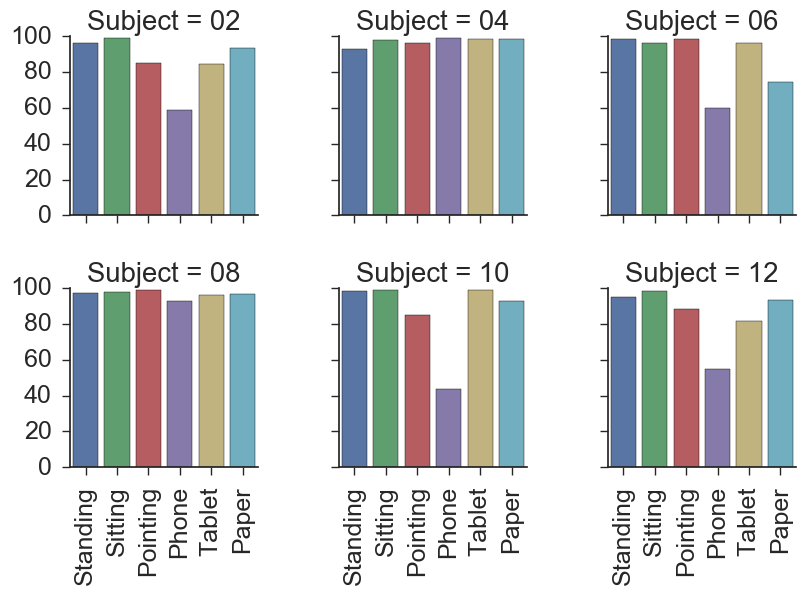

In [58]:
g = sns.FacetGrid(data=cs_cofnusion_matrix_subject_df, col="Subject", col_wrap=3)
g = (g.map(sns.barplot, "Activity", "Accuracy", palette=sns.color_palette(), ci=None)
     .set_xlabels("")
     .set_ylabels("")
     .set_xticklabels(rotation=90))
g.despine()
plt.yticks(np.arange(0, 101, 20))
g.fig.savefig("Q:\\p_eaglesense\\CHI\\figs\\even-subject-cs-1000dpi.png", bbox_inches="tight", dpi=1000)

In [46]:
all_subject_cs_df = pd.DataFrame(columns=["Subject", "Activity", "Accuracy"])
for subject_id, _, subject_confusion_matrix in cs_confusion_matrix_subjects:
    subject = str(subject_id)[2:4]
    for activity_id, activity in enumerate(ACTIVITIES):
        activity_accuracy = subject_confusion_matrix[activity_id, activity_id]
        all_subject_cs_df.loc[len(all_subject_cs_df)] = [subject, activity, activity_accuracy]

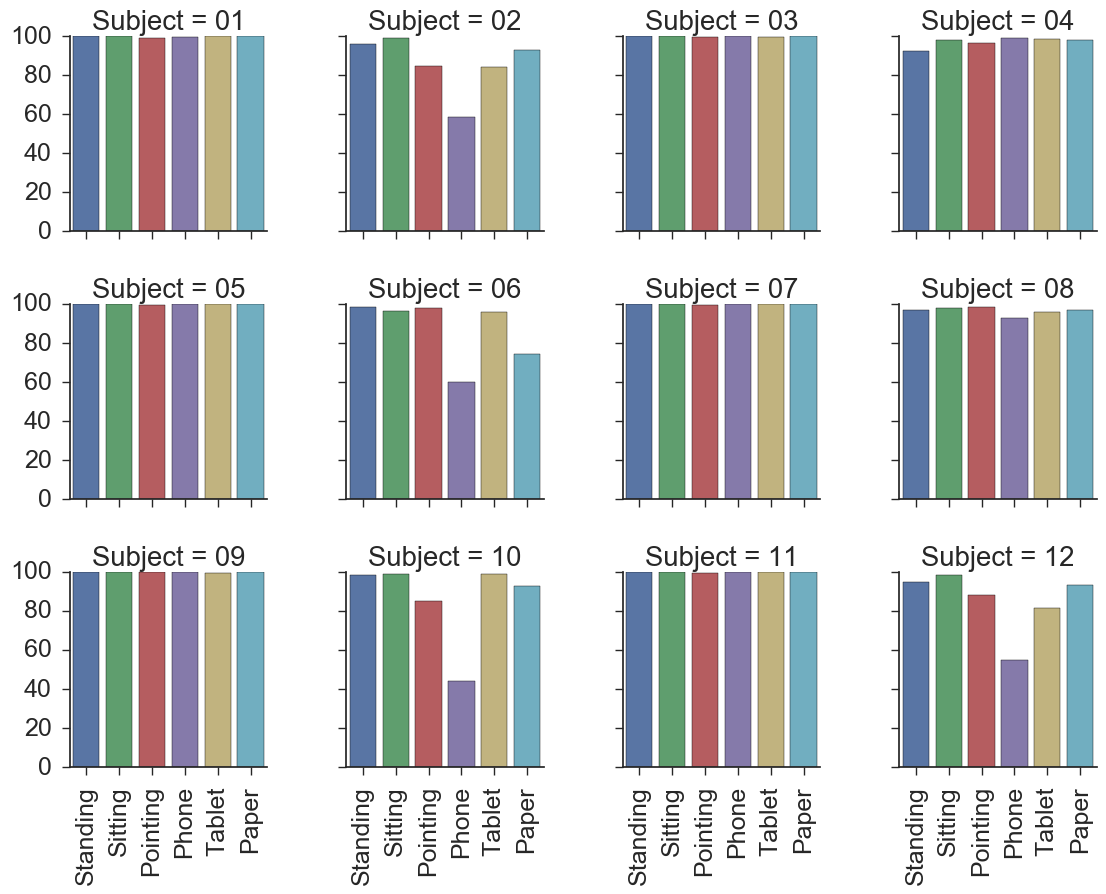

In [56]:
g = sns.FacetGrid(data=all_subject_cs_df, col="Subject", col_wrap=4)
g = (g.map(sns.barplot, "Activity", "Accuracy", palette=sns.color_palette(), ci=None)
     .set_xlabels("")
     .set_ylabels("")
     .set_xticklabels(rotation=90))
g.despine()
plt.yticks(np.arange(0, 101, 20))
g.fig.savefig("Q:\\p_eaglesense\\CHI\\figs\\all-subject-cs-1000dpi.png", bbox_inches="tight", dpi=1000)

#  CROSS SUBJECT TEST

In [87]:
feature_importance = cs_classifier.get_fscore()

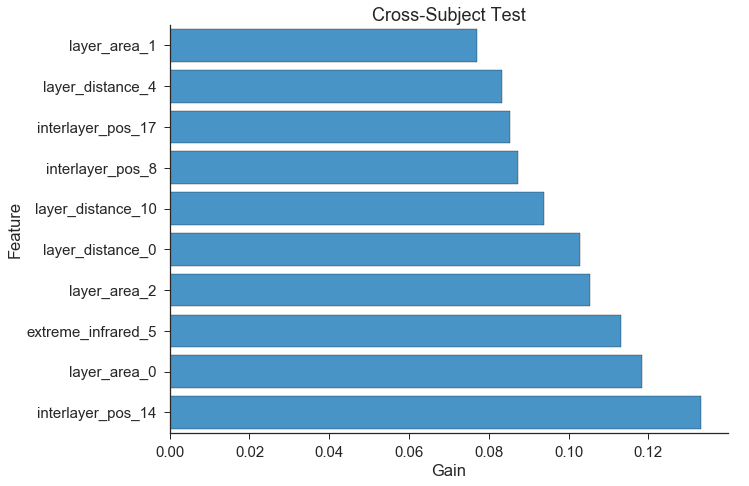

In [88]:
# Create feature importance dataframe
features_importance_formatted = dict()
for feature_idx, feature_name in enumerate(features_vector.columns):
    old_key = "f{}".format(feature_idx)
    if old_key not in feature_importance:
        continue
    new_key = feature_name
    features_importance_formatted[new_key] = feature_importance[old_key]
features_importance_formatted = sorted(features_importance_formatted.items(), key=operator.itemgetter(1))
features_importance_top10 = features_importance_formatted[-10:]
features_importance_df = pd.DataFrame(features_importance_top10, columns=["feature", "gain"])
features_importance_df["gain"] = features_importance_df["gain"] / features_importance_df["gain"].sum()

# Plot
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(x="gain", y="feature", data=features_importance_df, label="Total", color="#3498db", ax=ax)
sns.despine()
ax.set_xlabel("Gain")
ax.set_ylabel("Feature")
ax.set_title("Cross-Subject Test")

FIG_CS_FEATURE_IMPORTANCE = "cs_feature_importance"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_FEATURE_IMPORTANCE), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_FEATURE_IMPORTANCE), bbox_inches="tight")

In [89]:
np.set_printoptions(formatter={'float': lambda x: "{:.2f}".format(x)})

In [124]:
cs_cofnusion_matrix_subject_df = pd.DataFrame(columns=["Subject", "Activity", "Accuracy"])
for subject_id, _, subject_confusion_matrix in cs_confusion_matrix_subjects:
    subject = str(subject_id)[2:4]
    for activity_id, activity in enumerate(ACTIVITIES):
        activity_accuracy = subject_confusion_matrix[activity_id, activity_id]
        if subject_id % 2 == 0:
            cs_cofnusion_matrix_subject_df.loc[len(cs_cofnusion_matrix_subject_df)] = [subject, activity, activity_accuracy]
        if activity == "Phone":
            print("Subject", subject)
            print(subject_confusion_matrix[activity_id,:])

Subject 01
[0.49 0.00 0.00 99.51 0.00 0.00]
Subject 02
[11.37 0.00 0.00 58.60 25.95 4.08]
Subject 03
[0.00 0.00 0.00 100.00 0.00 0.00]
Subject 04
[0.13 0.00 0.00 99.22 0.65 0.00]
Subject 05
[0.00 0.00 0.00 100.00 0.00 0.00]
Subject 06
[38.74 0.00 0.00 59.85 1.42 0.00]
Subject 07
[0.00 0.00 0.00 100.00 0.00 0.00]
Subject 08
[5.73 0.00 0.00 92.83 1.08 0.36]
Subject 09
[0.00 0.00 0.00 100.00 0.00 0.00]
Subject 10
[53.25 0.00 0.00 43.92 2.77 0.06]
Subject 11
[0.00 0.00 0.00 100.00 0.00 0.00]
Subject 12
[44.32 0.00 0.00 54.94 0.41 0.34]


NameError: name 'FIG_TEMPLATE' is not defined

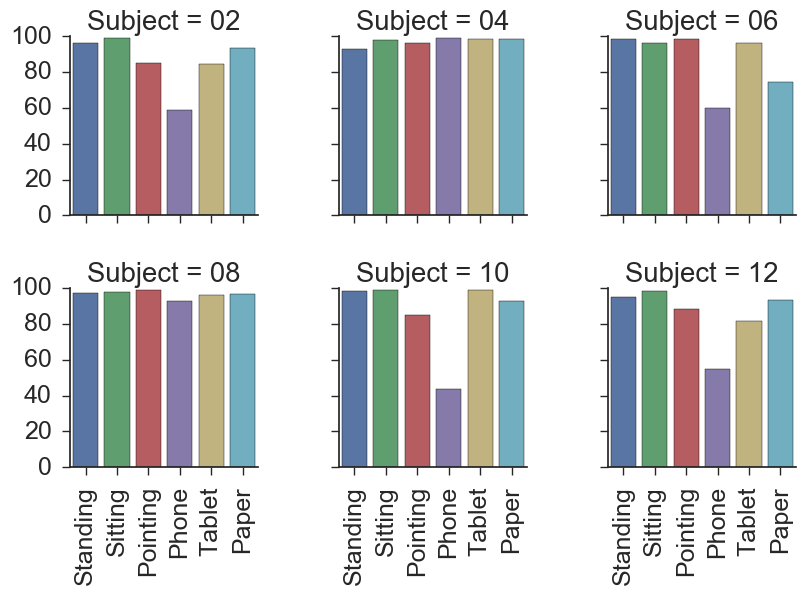

In [40]:
g = sns.FacetGrid(data=cs_cofnusion_matrix_subject_df, col="Subject", col_wrap=3)
g = (g.map(sns.barplot, "Activity", "Accuracy", palette=sns.color_palette(), ci=None)
     .set_xlabels("")
     .set_ylabels("")
     .set_xticklabels(rotation=90))
g.despine()
plt.yticks(np.arange(0, 101, 20))

FIG_CS_CONFUSION_MATRIX_SUBJECT = "cs_accuracy_subject"
g.fig.savefig(FIG_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_SUBJECT), bbox_inches="tight")
g.fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_SUBJECT), bbox_inches="tight")

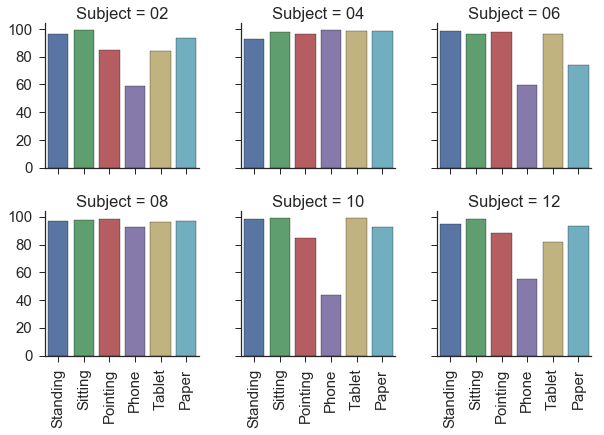

In [125]:
g = sns.FacetGrid(data=cs_cofnusion_matrix_subject_df, col="Subject", col_wrap=3)
g = (g.map(sns.barplot, "Activity", "Accuracy", palette=sns.color_palette(), ci=None)
     .set_xlabels("")
     .set_ylabels("")
     .set_xticklabels(rotation=90))
g.despine()
plt.yticks(np.arange(0, 101, 20))

FIG_CS_CONFUSION_MATRIX_SUBJECT = "cs_accuracy_subject"
g.fig.savefig(FIG_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_SUBJECT), bbox_inches="tight")
g.fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_SUBJECT), bbox_inches="tight")

# Random Forest 

In [92]:
rf_comparison_data = [
    {
        "Test": "Train",
        "Classifier": "Random Forest",
        "Time": cs_rf_training_time,
        "Accuracy": cs_rf_training_accuracy
    },
    {
        "Test": "Test",
        "Classifier": "Random Forest",
        "Time": cs_rf_testing_time,
        "Accuracy": cs_rf_accuracy
    },
    {
        "Test": "Train",
        "Classifier": "XGBoost",
        "Time": cs_training_time,
        "Accuracy": cs_training_accuracy
    },
    {
        "Test": "Test",
        "Classifier": "XGBoost",
        "Time": cs_testing_time,
        "Accuracy": cs_accuracy
    },
]

rf_comparison_df = pd.DataFrame(rf_comparison_data, columns=["Test", "Classifier", "Time", "Accuracy"])
rf_comparison_df.head()

,Test,Classifier,Time,Accuracy
0,Train,Random Forest,2.524389,1.000000
1,Test,Random Forest,0.270627,0.844388
2,Train,XGBoost,9.322780,1.000000
3,Test,XGBoost,0.231154,0.905464


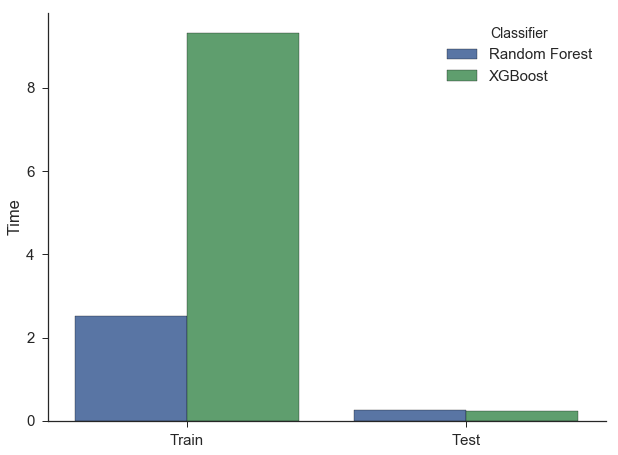

In [93]:
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=rf_comparison_df, x="Test", y="Time", hue="Classifier", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Time")
sns.despine()

FIG_CS_RANDOMFOREST_TIME = "cs_randomforest_time"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_RANDOMFOREST_TIME), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_RANDOMFOREST_TIME), bbox_inches="tight")

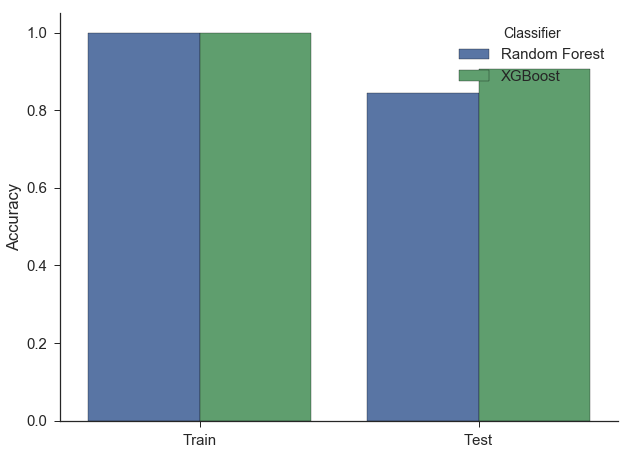

In [94]:
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=rf_comparison_df, x="Test", y="Accuracy", hue="Classifier", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Accuracy")
sns.despine()

FIG_CS_RANDOMFOREST_ACCURACY = "cs_randomforest_accuracy"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_RANDOMFOREST_ACCURACY), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_RANDOMFOREST_ACCURACY), bbox_inches="tight")

# No infrared 

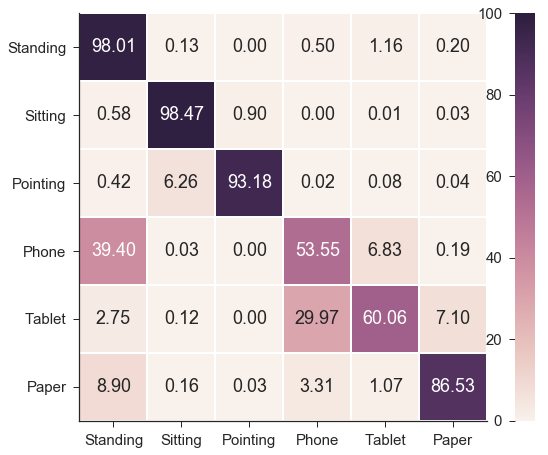

In [95]:
fig, ax = plot_confusion_matrix("Cross-Subject Test (No infrareds)", noinfrared_confusion_matrix)
FIG_CS_CONFUSION_MATRIX_NONINFRARED = "cs_noinfrared_confusion_matrix"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_NONINFRARED), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_NONINFRARED), bbox_inches="tight")

In [34]:
crosssubject_infrared_comparisons_df = pd.DataFrame(columns=["Activity", "Accuracy", "Condition"])

for activity_id, activity in enumerate(ACTIVITIES):
    infrared_accuracy = cs_confusion_matrix[activity_id, activity_id]
    noinfrared_accuracy = noinfrared_confusion_matrix[activity_id, activity_id]
    
    crosssubject_infrared_comparisons_df.loc[len(crosssubject_infrared_comparisons_df)] = [
        activity, infrared_accuracy, "All"
    ]
    crosssubject_infrared_comparisons_df.loc[len(crosssubject_infrared_comparisons_df)] = [
        activity, noinfrared_accuracy, "No infrareds"
    ]
    
    print(activity, infrared_accuracy - noinfrared_accuracy)

Standing -1.45393541172
Sitting -0.235607457488
Pointing -0.188956539996
Phone 10.2659664577
Tablet 33.1205107741
Paper 5.2005730659


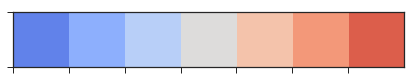

In [97]:
sns.palplot(sns.color_palette("coolwarm", n_colors=7))

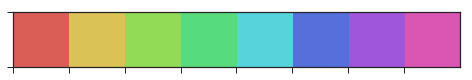

In [98]:
sns.palplot(sns.color_palette("hls", 8))

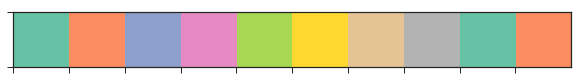

In [99]:
sns.palplot(sns.color_palette("Set2", 10))

In [100]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

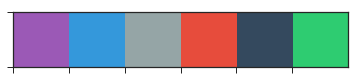

In [101]:
sns.palplot(sns.color_palette(flatui))

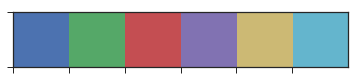

In [31]:
sns.palplot(sns.color_palette())

In [32]:
default_colors = sns.color_palette()

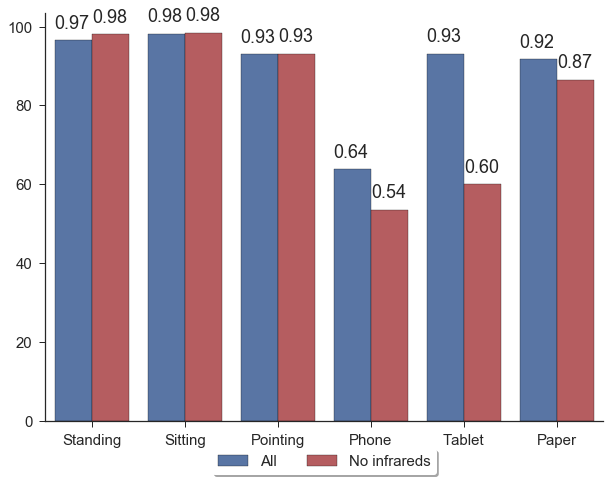

In [36]:
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=crosssubject_infrared_comparisons_df, ax=ax,
            x="Activity", y="Accuracy", hue="Condition", palette=[default_colors[0], default_colors[2]])
sns.despine()
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=True, framealpha=1, fancybox=True, shadow=True, ncol=2)
# ax.set_title("Cross-Subject Test")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+ 3, '%1.2f'%(height/100))

    
FIG_CS_INFRARED_COMPARISON = "cs_infrared_comparison"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_INFRARED_COMPARISON), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_INFRARED_COMPARISON), bbox_inches="tight")

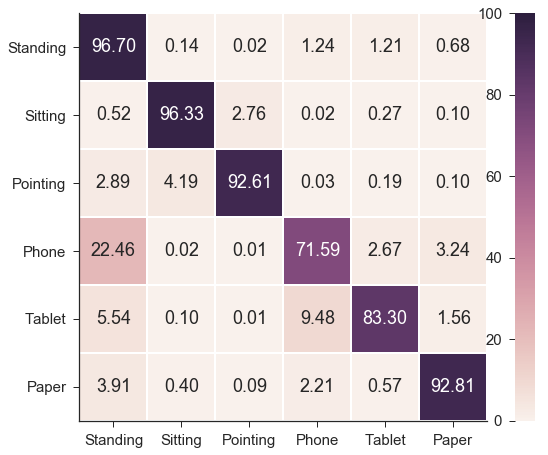

In [120]:
fig, ax = plot_confusion_matrix("Cross-Subject Test (All Combinations)", combinations_confusion_matrix)
FIG_CS_CONFUSION_MATRIX_ALL = "cs_all_confusion_matrix"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_ALL), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_CONFUSION_MATRIX_ALL), bbox_inches="tight")

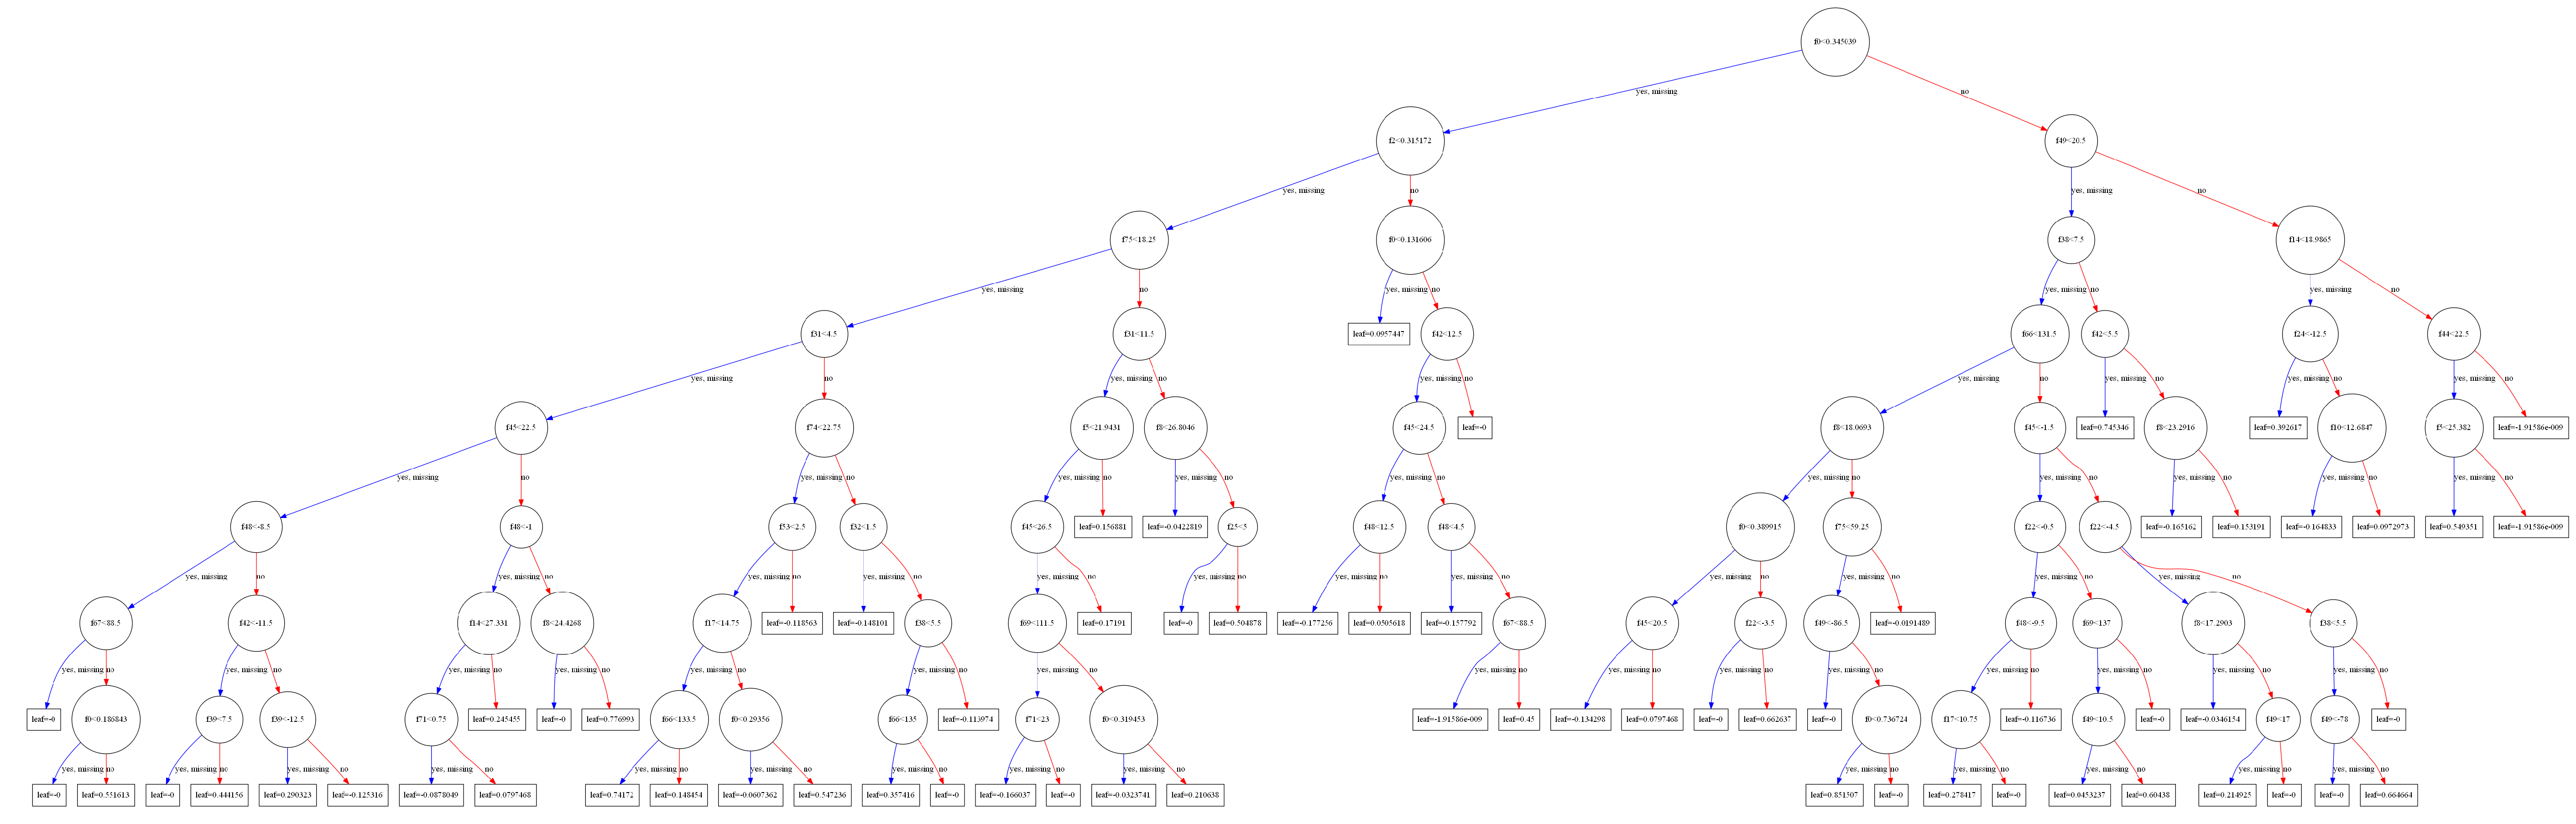

In [53]:
fig, ax = plt.subplots(figsize=(100,100))
xgb.plot_tree(cs_classifier, num_trees=0, rankdir="UT", ax=ax)
FIG_CS_CLASSIFIER = "cs_classifier"
fig.savefig(FIG_TEMPLATE.format(FIG_CS_CLASSIFIER), bbox_inches="tight")
fig.savefig(FIG_HIGH_TEMPLATE.format(FIG_CS_CLASSIFIER), bbox_inches="tight")